### Librerias y Funciones

In [0]:
spark.conf.set("spark.databricks.io.cache.enabled", True)
spark.conf.set('spark.sql.shuffle.partitions', 'auto')

In [0]:
%run ../../../../../04_utils/commons_functions_de

### Librerías

### Funciones Ingenieria de datos

### Funciones de ingesta en RDS

### Funciones de control de flujo de ingesta

In [0]:
%run ../../../../../04_utils/commons_functions_ds

In [0]:
%run ../../../../../spigot/initial/global_parameter_py

In [0]:
from IPython.display import display

# mute warnings
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pyspark.sql import Window
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import plotly.express as px

sns.set_theme(style="ticks")

from datetime import datetime
from dateutil.relativedelta import relativedelta

pd.set_option('display.float_format', lambda x: '%.5f' % x)

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql.functions import regexp_extract

from datetime import datetime, date

import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score


#### Carga de Fuente

In [0]:
int_pedidos_clientes = (spark.read.parquet("/Volumes/dbw_prod_aavanzada/db_tmp/files/pburbano/data/")
                                  .withColumn("fecha_pedido_dt", F.to_date(F.col("fecha_pedido_dt")))
                        )

### Prediccion del Canal del Ultimo Pedido del Cliente

#### Creacion de MDT 

In [0]:
# Definir ventana ordenada por fecha por cliente
window_cliente = Window.partitionBy("cliente_id")

# Obtener la última fecha por cliente
df = int_pedidos_clientes.withColumn("fecha_ultimo_pedido", F.max("fecha_pedido_dt").over(window_cliente))

# Marcar si es el último pedido
df = df.withColumn("es_ultimo", F.when(F.col("fecha_pedido_dt") == F.col("fecha_ultimo_pedido"), 1).otherwise(0))

# Crear el target 
df_target = df.filter("es_ultimo = 1").select(
    "cliente_id",
    F.when(F.col("canal_pedido_cd") == "DIGITAL", 1).otherwise(0).alias("target")
)

# eliminar clientes con mas de un pedido en la ultima fecha para evitar ambiguedades (es slo el 0.76% de los clientes)
df_target_unica = (df_target.groupBy("cliente_id").agg(F.count("*").alias("n_pedidos_ultima_fecha"))
                            .filter("n_pedidos_ultima_fecha = 1")
                            .drop("n_pedidos_ultima_fecha")      
                  )  
            
df_target = df_target.join(df_target_unica, on="cliente_id", how="inner")

# Crear historico del cliente antes de su ultimo pedido
df_historico = (df.filter(F.col("es_ultimo") == 0)
                  .join(df_target.select("cliente_id"), "cliente_id", "inner")   
                  .withColumn("dias_antes_ultimo",F.datediff(F.col("fecha_ultimo_pedido"), F.col("fecha_pedido_dt")))   
                  .withColumn("canal_pedido_cd", F.when(F.col("canal_pedido_cd") == "DIGITAL", "DIGITAL").otherwise("NO_DIGITAL"))
                )

df_historico = df_historico.repartition("cliente_id").persist(StorageLevel.MEMORY_AND_DISK)

# Número total de pedidos anteriores
f_pedidos = df_historico.groupBy("cliente_id").agg(
    F.count("*").alias("n_pedidos_previos"),
    F.countDistinct("canal_pedido_cd").alias("n_canales_utilizados")
)

# calcular días entre pedidos
w_orden = Window.partitionBy("cliente_id").orderBy("fecha_pedido_dt")
df_historico = df_historico.withColumn("dias_entre_pedidos", F.datediff("fecha_pedido_dt", F.lag("fecha_pedido_dt").over(w_orden)))

# agregar canal previo y cambio de canal
df_historico = df_historico.withColumn("canal_previo", F.lag("canal_pedido_cd").over(w_orden))
df_historico = df_historico.withColumn("cambio_canal", F.when(F.col("canal_previo") != F.col("canal_pedido_cd"), 1).otherwise(0))

# cambios hacia/desde digital
df_historico = df_historico.withColumn(
    "cambio_a_digital",
    F.when((F.col("canal_previo") != "DIGITAL") & (F.col("canal_pedido_cd") == "DIGITAL"), 1).otherwise(0)
)
df_historico = df_historico.withColumn(
    "cambio_desde_digital",
    F.when((F.col("canal_previo") == "DIGITAL") & (F.col("canal_pedido_cd") != "DIGITAL"), 1).otherwise(0)
)

f_frecuencia = df_historico.groupBy("cliente_id").agg(
    F.mean("dias_entre_pedidos").alias("dias_entre_pedidos_mean"),
    F.expr("percentile(dias_entre_pedidos, 0.5)").alias("dias_entre_pedidos_median"),
    F.min("dias_entre_pedidos").alias("dias_entre_pedidos_min"),
    F.max("dias_entre_pedidos").alias("dias_entre_pedidos_max")
)

# Conteo de cada canal
f_canales = df_historico.groupBy("cliente_id").pivot("canal_pedido_cd").count().fillna(0)
f_canales = (f_canales.withColumnRenamed("DIGITAL", "n_digital")
                     .withColumnRenamed("NO_DIGITAL", "n_no_digital")
            )

# Proporción de pedidos digitales
f_canales = f_canales.withColumn("prop_digital", F.col("n_digital")/(F.col("n_digital") + F.col("n_no_digital")))
            
# variables numericas
f_valores = (df_historico.groupBy("cliente_id").agg(
    F.sum("facturacion_usd_val").alias("facturacion_total"),
    F.avg("facturacion_usd_val").alias("facturacion_prom"),
    F.stddev("facturacion_usd_val").alias("facturacion_std"),
    F.sum("materiales_distintos_val").alias("materiales_distintos_total"),
    F.avg("materiales_distintos_val").alias("materiales_prom"),
    F.stddev("materiales_distintos_val").alias("materiales_std"),
    F.sum("cajas_fisicas").alias("cajas_fisicas_total"),
    F.avg("cajas_fisicas").alias("cajas_fisicas_prom"),
    F.stddev("cajas_fisicas").alias("cajas_fisicas_std"),
)
.fillna(0, subset=["facturacion_std", "materiales_std", "cajas_fisicas_std"])
)

# Canal mas reciente utilizado
f_ultimo_canal = df_historico.groupBy("cliente_id").agg(
    F.first("canal_pedido_cd", ignorenulls=True).alias("canal_mas_reciente")
)

# agregados de cambio de canal
f_cambio_canal = df_historico.groupBy("cliente_id").agg(
    F.sum("cambio_canal").alias("n_cambios_canal"),
    F.mean("cambio_canal").alias("prop_cambios_canal"),
    F.sum("cambio_a_digital").alias("n_cambios_a_digital"),
    F.sum("cambio_desde_digital").alias("n_cambios_desde_digital"),
    (F.sum("cambio_a_digital") / (F.sum("cambio_canal") + F.lit(1))).alias("prop_cambios_a_digital")
)

# variables temporales
df_historico = df_historico.withColumn("en_30d", F.when(F.col("dias_antes_ultimo") <= 30, 1).otherwise(0))
df_historico = df_historico.withColumn("en_60d", F.when(F.col("dias_antes_ultimo") <= 60, 1).otherwise(0))
df_historico = df_historico.withColumn("en_90d", F.when(F.col("dias_antes_ultimo") <= 90, 1).otherwise(0))

# Crear agregados por cliente
f_ventanas = (df_historico.groupBy("cliente_id").agg(
    F.min("dias_antes_ultimo").alias("dias_desde_ultimo_pedido"),

    F.sum("en_30d").alias("n_pedidos_ult_30d"),
    F.sum("en_60d").alias("n_pedidos_ult_60d"),
    F.sum("en_90d").alias("n_pedidos_ult_90d"),

    F.sum(F.when((F.col("en_30d") == 1), F.col("facturacion_usd_val"))).alias("facturacion_ult_30d"),
    F.sum(F.when((F.col("en_60d") == 1), F.col("facturacion_usd_val"))).alias("facturacion_ult_60d"),
    F.sum(F.when((F.col("en_90d") == 1), F.col("facturacion_usd_val"))).alias("facturacion_ult_90d"),
    
    F.max(F.when((F.col("en_30d") == 1) & (F.col("canal_pedido_cd") == "DIGITAL"), 1).otherwise(0)).alias("uso_digital_ult_30d"),
    F.max(F.when((F.col("en_60d") == 1) & (F.col("canal_pedido_cd") == "DIGITAL"), 1).otherwise(0)).alias("uso_digital_ult_60d"),
    F.max(F.when((F.col("en_90d") == 1) & (F.col("canal_pedido_cd") == "DIGITAL"), 1).otherwise(0)).alias("uso_digital_ult_90d")
)
.fillna(0, subset=["facturacion_ult_30d", "facturacion_ult_60d", "facturacion_ult_90d"])
)

w = Window.partitionBy("cliente_id").orderBy(F.desc("fecha_pedido_dt"))
df_last3 = (
    df_historico.withColumn("rn", F.row_number().over(w))
    .filter(F.col("rn") <= 3)
    .groupBy("cliente_id")
    .agg(
        F.avg("facturacion_usd_val").alias("facturacion_last3"),
        F.avg("materiales_distintos_val").alias("materiales_last3"),
        F.avg("cajas_fisicas").alias("cajas_last3")
    )
)

f_tendencias = df_last3.join(
    f_valores.select("cliente_id", "facturacion_prom", "materiales_prom", "cajas_fisicas_prom"),"cliente_id","left"
)
f_tendencias = (f_tendencias.withColumn("tendencia_facturacion", F.col("facturacion_last3") / (F.col("facturacion_prom") + F.lit(1)))
                           .withColumn("tendencia_materiales", F.col("materiales_last3") / (F.col("materiales_prom") + F.lit(1)))
                           .withColumn("tendencia_cajas", F.col("cajas_last3") / (F.col("cajas_fisicas_prom") + F.lit(1)))
                )

# variables que no cambian en el tiempo
f_variables_fijas = (df_historico.groupBy("cliente_id").agg(
    F.first("pais_cd").alias("pais_cd"),
    F.first("region_comercial_txt").alias("region_comercial_txt"),
    F.first("tipo_cliente_cd").alias("tipo_cliente_cd"),
    F.first("madurez_digital_cd").alias("madurez_digital_val"),
    F.first("estrellas_txt").cast("int").alias("estrellas_val"), 
    F.length(F.first("frecuencia_visitas_cd")).alias("frecuencia_visitas_val"),
    F.first("fecha_ultimo_pedido").cast("timestamp").alias("fecha_ultimo_pedido")
)) 

# tendencia en uso digital
df_historico = df_historico.withColumn("canal_digital_bin", F.when(F.col("canal_pedido_cd") == "DIGITAL", 1).otherwise(0))

df_last3_digital = (
    df_historico.withColumn("rn", F.row_number().over(w))
    .filter(F.col("rn") <= 3)
    .groupBy("cliente_id")
    .agg(F.avg("canal_digital_bin").alias("uso_digital_last3"))
)

f_tendencia_digital = df_last3_digital.join(
    f_canales.select("cliente_id", F.col("prop_digital").alias("prop_digital_ref")),
    "cliente_id",
    "left"
)
f_tendencia_digital = f_tendencia_digital.fillna({"uso_digital_last3": 0, "prop_digital_ref": 0})
f_tendencia_digital = f_tendencia_digital.withColumn(
    "tendencia_digital", F.when(F.col("uso_digital_last3") > F.col("prop_digital_ref"), 1).otherwise(0)
)

# informacion de agencia y ruta
df_historico = (df_historico.withColumn("agencia_num", regexp_extract(F.col("agencia_id"), r"A(\d+)$", 1).cast("int"))
                            .withColumn("ruta_num", regexp_extract(F.col("ruta_id"), r"R(\d+)$", 1).cast("int"))
)

f_ruta_agencia = (df_historico.groupBy("cliente_id").agg(
    F.first("agencia_num").alias("agencia_num"),
    F.first("ruta_num").alias("ruta_num")
))                                          

# mdt final
df_mdt = (f_pedidos
          .join(f_canales, "cliente_id", "left")
          .join(f_valores, "cliente_id", "left")
          .join(f_frecuencia, "cliente_id", "left")
          .join(f_ventanas, "cliente_id", "left")
          .join(f_tendencias.select("cliente_id", "tendencia_facturacion", "tendencia_materiales", "tendencia_cajas"), "cliente_id", "left")
          .join(f_tendencia_digital.select("cliente_id", "uso_digital_last3", "tendencia_digital"), "cliente_id", "left")
          .join(f_ultimo_canal, "cliente_id", "left")
          .join(f_cambio_canal, "cliente_id", "left")  
          .join(f_ruta_agencia, "cliente_id", "left")
          .join(f_variables_fijas, "cliente_id", "left")
          .join(df_target, "cliente_id", "inner")
)


#### Modelamiento

In [0]:
df_mdt_pd = df_mdt.toPandas()

#### Ajustes finales a variables

In [0]:
df_features_pd = df_mdt_pd.copy()

df_features_pd = df_features_pd.fillna(0)

#df_features_pd = df_features_pd.drop(columns=["madurez_digital_val"])

# dividir en train y test
df_features_pd["fecha_ultimo_pedido"] = df_features_pd["fecha_ultimo_pedido"].dt.date
df_train = df_features_pd[df_features_pd["fecha_ultimo_pedido"] < date(2024,8,1)]
df_test = df_features_pd[df_features_pd["fecha_ultimo_pedido"] >= date(2024,8,1)]

##### Validacion de balance en muestras y target

In [0]:
# proporcion train/test
df_test.shape[0] / (df_test.shape[0] + df_train.shape[0])

0.27385232766398687

In [0]:
# proporcion de target en train
df_train["target"].value_counts(normalize=True)

target
0   0.52016
1   0.47984
Name: proportion, dtype: float64

In [0]:
# proporcion de target en test
df_test["target"].value_counts(normalize=True)

target
0   0.51731
1   0.48269
Name: proportion, dtype: float64

##### LightGBM

In [0]:
# creacion de df de entrenamiento y prueba
cols_exclude = ["cliente_id", "fecha_ultimo_pedido", "target"]

X_train = df_train.copy().drop(cols_exclude, axis=1)
X_test = df_test.copy().drop(cols_exclude, axis=1)

y_train = df_train.copy()["target"]
y_test = df_test.copy()["target"]

# tratamiento adicional de categoricas

categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

for col in categorical_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

# modelo con algunos paramtros modificados para evitar sobreajuste 

model = LGBMClassifier(
    objective="binary",
    learning_rate=0.01,
    n_estimators=1200, # menos arboles
    num_leaves=31, # reduce complejidad de arboles
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=3.0, # penaliza pesos grandes
    reg_lambda=3.0, # distribuye importancia en features
    min_child_samples=150,
    class_weight="balanced",
    random_state=2022
)


# Callbacks para early stopping y logging
callbacks = [
    lgb.early_stopping(stopping_rounds=10),
    lgb.log_evaluation(period=0) 
]

# Entrenar (sin early_stopping_rounds directo)
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=callbacks,
    categorical_feature=categorical_cols  
)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 51749, number of negative: 56097
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5384
[LightGBM] [Info] Number of data points in the train set: 107846, number of used features: 47
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 

LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
               learning_rate=0.01, max_depth=6, min_child_samples=150,
               n_estimators=1200, objective='binary', random_state=2022,
               reg_alpha=3.0, reg_lambda=3.0, subsample=0.8)

##### Metricas Train

In [0]:
# Evaluación Train
y_pred_train = model.predict(X_train)
y_proba_train = model.predict_proba(X_train)[:, 1]

print("ROC AUC:", roc_auc_score(y_train, y_proba_train))
print("Classification report:\n", classification_report(y_train, y_pred_train))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
ROC AUC: 0.6612782797043171
Classification report:
               precision    recall  f1-score   support

           0       0.65      0.63      0.64     56097
           1       0.61      0.63      0.62     51749

    accuracy                           0.63    107846
   macro avg       0.63      0.63      0.63    107846
weighted avg       0.63      0.63      0.63    107846



##### Metricas Test

In [0]:
# Evaluación Test
y_pred_test = model.predict(X_test)
y_proba_test = model.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_proba_test))
print("Classification report:\n", classification_report(y_test, y_pred_test))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
ROC AUC: 0.648688707290185
Classification report:
               precision    recall  f1-score   support

           0       0.65      0.62      0.63     21040
           1       0.61      0.63      0.62     19632

    accuracy                           0.63     40672
   macro avg       0.63      0.63      0.63     40672
weighted avg       0.63      0.63      0.63     40672



##### Analisis de Caracteristicas

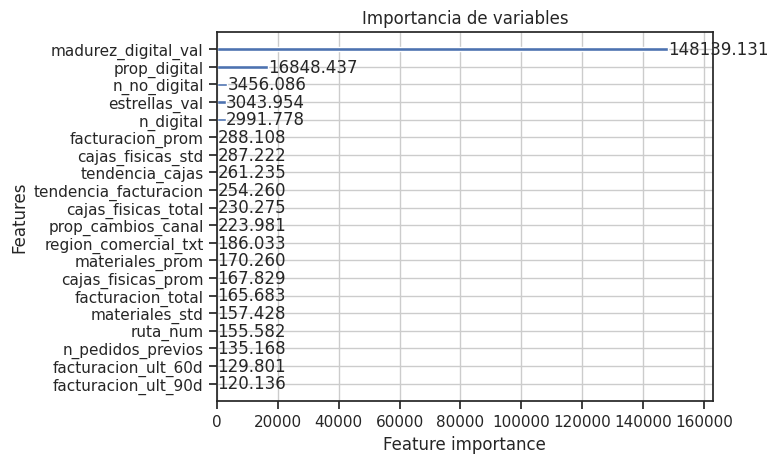

In [0]:
# importancia de caracteristicas
lgb.plot_importance(model, max_num_features=20, importance_type='gain') 
plt.title("Importancia de variables")
plt.show()

##### Analisis por segmentos de madurez

In [0]:
df_test_2 = df_test.copy()
df_test_2["madurez_digital_val"] = df_mdt_pd.loc[df_test_2.index, "madurez_digital_val"].values

# Evaluar por cada nivel de madurez
for nivel in df_test_2["madurez_digital_val"].dropna().unique():
    subset = df_test_2[df_test_2["madurez_digital_val"] == nivel]
    X_seg = X_test.loc[subset.index]
    y_seg = y_test.loc[subset.index]
    
    preds_proba = model.predict_proba(X_seg)[:, 1]
    preds_bin = (preds_proba >= 0.5).astype(int)
    
    auc = roc_auc_score(y_seg, preds_proba)
    cm = confusion_matrix(y_seg, preds_bin)
    
    print(f"\n=== {nivel} ===")
    print(f"AUC: {auc:.4f}")
    print("Matriz de confusión:")
    print(cm)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

=== BAJA ===
AUC: 0.4948
Matriz de confusión:
[[10998  2099]
 [ 6049  1141]]
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

=== ALTA ===
AUC: 0.5000
Matriz de confusión:
[[ 111 1374]
 [ 301 4261]]
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

=== MEDIA ===
AUC: 0.5000
Matriz de confusión:
[[2545 3913]
 [3092 4788]]
